# 基于ConvCNP的空间预测实验

## 显示数据情况

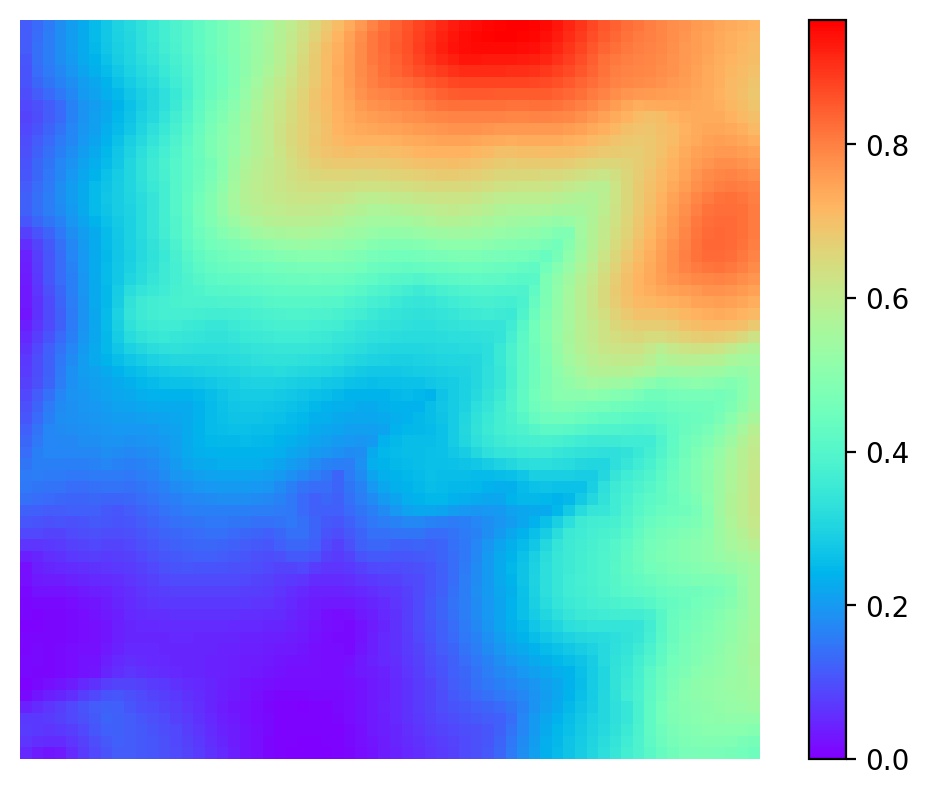

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import torch

os.chdir("./")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

# N_THREADS = 16
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

# torch.set_num_threads(N_THREADS)

from utils.data import get_train_test_img_dataset
import matplotlib.pyplot as plt

datasets_plot = dict()
datasets_plot["Train"], datasets_plot["Test"] = get_train_test_img_dataset("dem30m")

dataset = datasets_plot["Train"]
img_tensor = torch.tensor(
        dataset[2][0]
    )
plt.imshow(img_tensor[0,:,:].numpy(),cmap='rainbow')
plt.axis("off")
plt.colorbar()

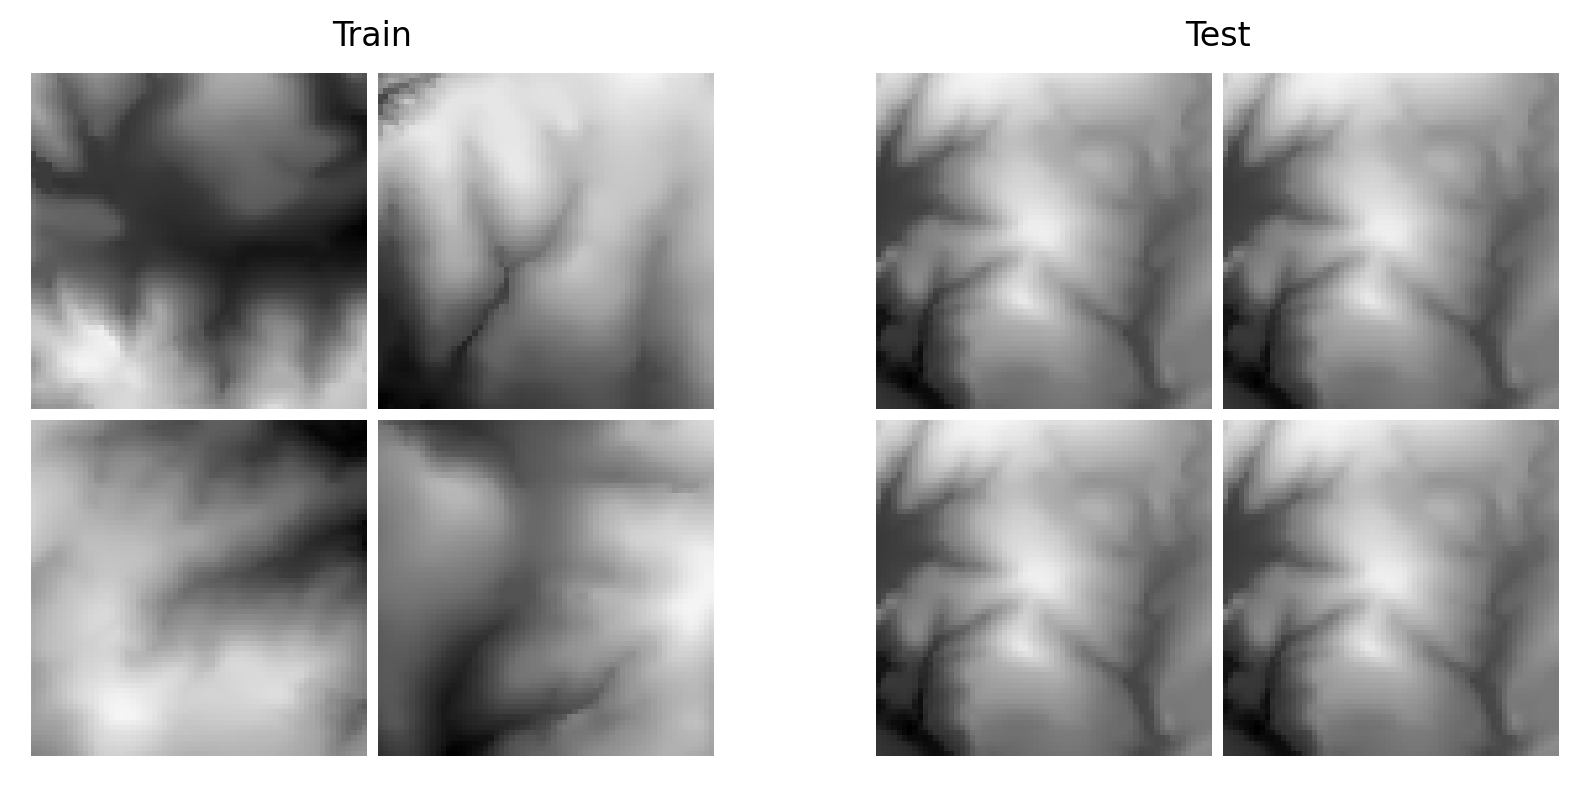

In [9]:
import matplotlib.pyplot as plt
from utils.visualize import plot_dataset_samples_imgs
from utils.data import get_train_test_img_dataset
from torchvision.utils import make_grid
import random

datasets_plot = dict()
datasets_plot["Train"], datasets_plot["Test"] = get_train_test_img_dataset("dem30m")
n_datasets = len(datasets_plot)
fig, axes = plt.subplots(1, n_datasets, figsize=(5 * n_datasets, 5))
for i, (k, dataset) in enumerate(datasets_plot.items()):
    n_plots=4
    img_tensor = torch.stack(
        [dataset[random.randint(0, len(dataset) - 1)][0] for i in range(n_plots)], dim=0
    )
    ax=axes[i]
    grid = make_grid(img_tensor, nrow=2, pad_value=1, normalize=False, value_range=())
    ax.imshow(grid.permute(1, 2, 0).numpy(), cmap='rainbow')
    
    ax.axis("off")
    ax.set_title(k)
    # plot_dataset_samples_imgs(dataset, n_plots=4, title=k, ax=axes[i], seed=2445, value_range=(100,300))


## 构建数据集

In [12]:
from utils.ntbks_helpers import get_img_datasets

img_datasets, img_test_datasets = get_img_datasets(["dem30m"])

from npf.utils.datasplit import (
    GridCntxtTrgtGetter,
    RandomMasker,
    no_masker,
)
from utils.data import cntxt_trgt_collate

# CONTEXT TARGET SPLIT
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    ),
    is_return_masks=True,  # will be using grid conv CNP => can work directly with mask
)
print(get_cntxt_trgt_2d)

<function cntxt_trgt_collate.<locals>.mycollate at 0x7f9cb2006f70>


## 构建模型

In [13]:
from functools import partial

from npf import GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # 字典存储解码器函数
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0 #解码器采用MLP，隐藏层数为4，隐藏层大小为128
    ),
)

# 编码器采用CNN，采用ResNet结构，用总共10层，卷积核大小为9
CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  
    n_conv_layers=2,  # 每个卷积块的卷积层数
)

model_2d = partial(
    GridConvCNP,
    x_dim=1,  
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv2d,
        Normalization=torch.nn.BatchNorm2d,
        n_blocks=5,
        kernel_size=9,
        **CNN_KWARGS,
    ),
    **KWARGS,
)

n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (2D): {n_params_2d:,d}")


Number Parameters (2D): 340,721


## 训练/加载模型

In [16]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # 训练还是直接加载模型
    criterion=CNPFLoss,
    chckpnt_dirname="/Users/alex/Downloads/project_2201213292_李锦韬/code/results/",
    device=None,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    # batch_size=32,
)

models_2d = add_y_dim(
    {"ConvCNP": model_2d}, img_datasets
)  # y_dim (channels) depend on data


# 2D
trainers_2d = train_models(
    img_datasets,
    models_2d,
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # 10% for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    max_epochs=50,
    batch_size=32,
    **KWARGS
)


--- Loading dem30m/ConvCNP/run_0 ---

dem30m/ConvCNP/run_0 | best epoch: 44 | train loss: -11277.7759 | valid loss: -11294.9283 | test log likelihood: 10530.3776


## 制作预测结果可视化的图像

In [ ]:
from utils.ntbks_helpers import PRETTY_RENAMER,plot_multi_posterior_samples_imgs
from utils.visualize import giffify

SWEEP_VALUES=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half
            "vhalf",  # vertival half
        ]

def multi_posterior_imgs_gif(
    filename, trainers, datasets, seed=123, n_plots=3, sweep_values=SWEEP_VALUES, fps=1, is_plot_std=True, plot_config_kwargs={"font_scale":0.7}, **kwargs
):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  
        sweep_parameter="n_cntxt",  
        sweep_values=sweep_values,
        fps=fps,
        
        trainers=trainers,
        datasets=datasets,
        n_plots=n_plots,  
        is_plot_std=is_plot_std,  
        pretty_renamer=PRETTY_RENAMER,  
        plot_config_kwargs=plot_config_kwargs,
        
        seed=seed,
        **kwargs,
    )


multi_posterior_imgs_gif(
    "dem_ConvCNP_img", trainers=trainers_2d, datasets=img_test_datasets,
)